<a href="https://colab.research.google.com/github/entelecheia/378A/blob/main/notebooks/07/02_sentiment_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naver Movie Review Sentiment Analysis

In [4]:
%%capture
%pip install ekorpkit[dataset,tokenize]==0.1.21.post0.dev14 -U

#### 데이터셋 로드

In [5]:
from ekorpkit import eKonf

cfg = eKonf.compose(config_group='dataset/simple=nsmc')
cfg.data_dir = './data/nsmc'
cfg.fetch.data_dir = cfg.data_dir
cfg.fetch.overwrite = True
cfg.fetch.calculate_stats = True
db = eKonf.instantiate(cfg)
db.build()

Loading [train] documents from huggingface datasets [nsmc]


Using custom data configuration default


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset nsmc downloaded and prepared to /root/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.
Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 150000
})
✔  >> elapsed time to load and parse data: 0:00:23.170083

Transforming dataframe with pipeline: ['rename_columns', 'reset_index', 'replace', 'save_metadata']
Applying pipeline: OrderedDict([('rename_columns', 'rename_columns'), ('reset_index', 'reset_index'), ('replace', 'replace'), ('save_metadata', 'save_metadata')])

Applying pipe: functools.partial(<function rename_columns at 0x7f12e83d1200>)

Applying pipe: functools.partial(<function reset_index at 0x7f12e83d1290>)

Applying pipe: functools.partial(<function general_function at 0x7f12e83d1680>)

Applying pipe: functools.partial(<function save_metadata at 0x7f12e83d1d40>)

Processing dataframe with pipeline: ['save_samples', 'save_dataframe']
Applying pipeline

apply len_bytes to num_bytes:   0%|          | 0/150000 [00:00<?, ?it/s]

✔  >> elapsed time to calculate statistics: 0:00:00.609191
Loading [test] documents from huggingface datasets [nsmc]


Using custom data configuration default
Reusing dataset nsmc (/root/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 50000
})
✔  >> elapsed time to load and parse data: 0:00:00.484690

Transforming dataframe with pipeline: ['rename_columns', 'reset_index', 'replace', 'save_metadata']
Applying pipeline: OrderedDict([('rename_columns', 'rename_columns'), ('reset_index', 'reset_index'), ('replace', 'replace'), ('save_metadata', 'save_metadata')])

Applying pipe: functools.partial(<function rename_columns at 0x7f12e83d1200>)

Applying pipe: functools.partial(<function reset_index at 0x7f12e83d1290>)

Applying pipe: functools.partial(<function general_function at 0x7f12e83d1680>)

Applying pipe: functools.partial(<function save_metadata at 0x7f12e83d1d40>)

Processing dataframe with pipeline: ['save_samples', 'save_dataframe']
Applying pipeline: OrderedDict([('save_samples', 'save_samples'), ('save_dataframe', 'save_dataframe')])

Applying pipe: functools.partial(<function save_samples at 0x7f12e83d19e0>)

Applying pipe: functools.partial(

apply len_bytes to num_bytes:   0%|          | 0/50000 [00:00<?, ?it/s]

✔  >> elapsed time to calculate statistics: 0:00:00.276956

Corpus [nsmc] is built to [./data/nsmc] from [./data/nsmc]


In [6]:
cfg = eKonf.compose(config_group='dataset=dataset')
cfg.name = 'nsmc'
cfg.data_dir = './data'
ds = eKonf.instantiate(cfg)

Loading data from data/nsmc/nsmc-train.csv
Loading data from data/nsmc/nsmc-test.csv


#### 훈련용 데이터셋 크기 확인

In [9]:
train_data = ds.splits['train']
print('훈련용 리뷰 개수 : ', len(train_data))

훈련용 리뷰 개수 :  150000


#### 훈련용 데이터셋 구성 확인

In [10]:
train_data.head()

,id,labels,text
0,0,negative,아 더빙.. 진짜 짜증나네요 목소리
1,1,positive,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2,2,negative,너무재밓었다그래서보는것을추천한다
3,3,negative,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4,4,positive,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...


#### 테스트용 데이터셋 크기 확인



In [37]:
test_data = ds.splits['test'].copy()
print('테스트용 리뷰 개수 : ', len(test_data))

테스트용 리뷰 개수 :  50000


#### 테스트용 데이터셋 구성 확인

In [38]:
test_data.head(5)

,id,labels,text
0,0,positive,굳 ㅋ
1,1,negative,GDNTOPCLASSINTHECLUB
2,2,negative,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3,3,negative,지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4,4,negative,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??


### 데이터 정제하기

<br>

#### 6.1.2.1 중복 데이터 확인 및 제거

- 먼저 `train_data`에 중복된 데이터가 있는 지 확인해보자.

In [39]:
train_data['text'].nunique(), train_data['labels'].nunique()

(143681, 2)

- 중복 샘플을 제거해보자.

In [40]:
train_data.drop_duplicates(subset=['text'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


- 정말 중복 샘플이 제거되었는 지 전체 샘플 수를 확인해보자.

In [41]:
print('총 샘플의 수 : ', len(train_data))

총 샘플의 수 :  143681


#### 레이블 값의 분포 확인

- `train_data`에서 해당 리뷰의 긍, 부정 유무가 기재되어 있는 레이블(labels)값의 분포를 확인해보자.

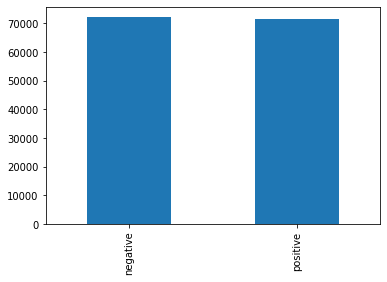

In [42]:
train_data['labels'].value_counts().plot(kind='bar')

In [43]:
print(train_data.groupby('labels').size().reset_index(name='count'))

     labels  count
0  negative  72215
1  positive  71466


#### 결측값 확인 및 제거

- 리뷰 중에 Null 값을 가진 샘플이 있는 지는 Pandas의 `isnull().values.any()`로 확인해보자.

In [44]:
print(train_data.isnull().values.any())

False


- `True`가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미이다.

- 어떤 열에 존재하는 지 확인해보자.

In [45]:
print(train_data.isnull().sum())

id        0
labels    0
text      0
dtype: int64


- 리뷰가 적혀있는 `text` 열에서 Null 값을 가진 샘플이 총 1개가 존재한다고 한다.
- 그렇다면 `text` 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는 지 한번 출력해보자.

In [46]:
train_data.loc[train_data.text.isnull()]

,id,labels,text


- Null 값을 가진 샘플을 제거해보자.

In [47]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


- Null 값을 가진 샘플이 제거되었다.

In [48]:
print(len(train_data))

143681


#### 정규 표현식 활용 데이터 전처리

- 이제 데이터의 전처리를 수행해보자.
- 위의 `train_data`와 `test_data`에서 온점(.)이나 물음표(?)와 같은 각종 특수문자가 사용된 것을 확인했다.
- `train_data`로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용해보자.

- 우선 한글이 아니라 영어의 경우를 상기해보자.
- 영어의 알파벳들을 나타내는 정규 표현식은 `[a-zA-Z]`이다.
- 이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식이다.
- 이를 응용하면 영어에 속하지 않는 구두점이나 특수 문자를 제거할 수 있다.
- 예를 들어 알파벳과 공백을 제외하고 모두 제거하는 전처리를 수행하는 예제는 다음과 같다.

In [49]:
import re

text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'

re.sub(r'[^a-zA-Z ]', '', text)

'do you expect people to read the FAQ etc and actually accept hard atheism'

<br>

- 위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 된다.
- 우선 자음과 모음의 대한 범위를 지정해보자.
- 일반적으로 자음의 범위는 `ㄱ ~ ㅎ`, 모음의 범위는 `ㅏ ~ ㅣ`와 같이 지정할 수 있다.
- 해당 범위 내에 어떤 자음과 모음이 속하는 지 알고 싶다면 [해당 링크](https://www.unicode.org/charts/PDF/U3130.pdf)를 참고하면 된다.
  - `ㄱ ~ ㅎ` : `3131` ~ `314E`
  - `ㅏ ~ ㅣ` : `314F` ~ `3163`

- 또한 완성형 한글의 범위는 `가 ~ 힣`과 같이 사용한다.
- 해당 범위 내에 포함된 음절들은 [해당 링크](https://www.unicode.org/charts/PDF/UAC00.pdf)에서 확인할 수 있다.

<br>

- 위의 범위 지정을 모두 반영하여 `train_data`에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해보자.

In [50]:
train_data.head()

,id,labels,text
0,0,negative,아 더빙 진짜 짜증나네요 목소리
1,1,positive,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2,2,negative,너무재밓었다그래서보는것을추천한다
3,3,negative,교도소 이야기구먼 솔직히 재미는 없다평점 조정
4,4,positive,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...


In [51]:
# 한글과 공백을 제외하고 모두 제거
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

In [52]:
train_data.head()

,id,labels,text
0,0,negative,아 더빙 진짜 짜증나네요 목소리
1,1,positive,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2,2,negative,너무재밓었다그래서보는것을추천한다
3,3,negative,교도소 이야기구먼 솔직히 재미는 없다평점 조정
4,4,positive,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...


- 상위 5개의 샘플을 다시 출력해보았는데, 정규 표현식을 수행하자 기존의 공백. 즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었다.
- 그런데 사실 네이버 영화 리뷰는 굳이 한글이 아니라 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있다.
- 다시 말해 기존에 한글이 없는 리뷰였다면 이제 더 이상 아무런 값도 없는 빈(empty)값이 되었을 것이다.

- `train_data`에 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, 다시 한번 Null 값이 존재하는 지 확인해보자.

In [53]:
import numpy as np
train_data['text'].replace('', np.nan, inplace=True)
print(train_data['text'].isnull().sum())

0


- Null 값이 391개나 새로 생겼다.

- Null 값이 있는 행을 5개만 출력해보자.

In [54]:
train_data.loc[train_data['text'].isnull()].head()

,id,labels,text


- Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있다.
- 사실 아무런 의미도 없는 데이터므로 제거해준다.

In [55]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

143681


- 샘플 개수가 또 다시 줄어서 이제 145,791개가 남았다.

#### 테스트 데이터 전처리

- 테스트 데이터에 지금까지 진행했던 전처리 과정들을 동일하게 진행한다.

In [56]:
# document 열에서 중복인 내용이 있다면 중복 제거
test_data.drop_duplicates(subset=['text'], inplace=True)

# 정규 표현식 수행
test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

# 공백은 Null 값으로 변경
test_data['text'].replace('', np.nan, inplace=True)

# Null 값 제거
test_data = test_data.dropna(how='any')

print('전처리 후 테스트용 샘플의 개수 : ', len(test_data))

전처리 후 테스트용 샘플의 개수 :  48995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


### Normalization

In [58]:
config_group='preprocessor/normalizer=formal_ko'
cfg_norm = eKonf.compose(config_group=config_group)
eKonf.pprint(cfg_norm)
norm = eKonf.instantiate(cfg_norm)

{'_target_': 'ekorpkit.preprocessors.normalizer.Normalizer',
 'ftfy': {'decode_inconsistent_utf8': True,
          'fix_c1_controls': True,
          'fix_character_width': True,
          'fix_encoding': True,
          'fix_latin_ligatures': True,
          'fix_line_breaks': True,
          'fix_surrogates': True,
          'max_decode_length': 1000000,
          'normalization': 'NFKC',
          'remove_control_chars': True,
          'remove_terminal_escapes': True,
          'replace_lossy_sequences': True,
          'restore_byte_a0': True,
          'uncurl_quotes': True,
          'unescape_html': True},
 'hanja2hangle': True,
 'num_repeats': 2,
 'spaces': {'collapse_whitespaces': True,
            'fix_whitespaces': True,
            'num_spaces_for_tab': 4,
            'replace_tabs': True,
            'strip': True},
 'special_characters': {'fix_ellipsis': True,
                        'fix_emoticons': False,
                        'fix_hyphens': True,
                   

### Tokenization

#### 불용어 정의

- 토큰화 과정에서 불용어를 제거한다.
- 불용어는 정의하기 나름이지만, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수 있다.
- 하지만 결국 풀고자 하는 문제의 데이터를 지속적으로 검토하면서 계속해서 추가하는 경우 또한 많다.
- 실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용하기도 한다.

In [57]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

#### 형태소 분석기 `Mecab`


In [60]:
config_group='preprocessor/tokenizer=mecab'
cfg = eKonf.compose(config_group=config_group)
cfg['normalize'] = cfg_norm
eKonf.pprint(cfg)
mecab = eKonf.instantiate(cfg)

[ekorpkit]: Initializing mecab...


{'_target_': 'ekorpkit.preprocessors.tokenizer.MecabTokenizer',
 'extract': {'no_space_for_non_nouns': False,
             'noun_postags': ['NNG', 'NNP', 'XSN', 'SL', 'XR', 'NNB', 'NR'],
             'postags': None,
             'stop_postags': ['SP'],
             'stopwords': None,
             'stopwords_path': None},
 'mecab': {'backend': 'mecab-python3', 'userdic_path': None, 'verbose': False},
 'normalize': {'_target_': 'ekorpkit.preprocessors.normalizer.Normalizer',
               'ftfy': {'decode_inconsistent_utf8': True,
                        'fix_c1_controls': True,
                        'fix_character_width': True,
                        'fix_encoding': True,
                        'fix_latin_ligatures': True,
                        'fix_line_breaks': True,
                        'fix_surrogates': True,
                        'max_decode_length': 1000000,
                        'normalization': 'NFKC',
                        'remove_control_chars': True,
        

In [61]:
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와',
 '이런',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤직',
 '비디오',
 '를',
 '만드',
 '는',
 '게',
 '나을',
 '뻔']

#### 토큰화 및 불용어 제거

- 이제 `train_data`에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 `X_train`에 저장한다.

In [63]:
X_train = []

for sentence in train_data['text']:
    temp_X = []
    temp_X = mecab.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

In [64]:
print(X_train[:3])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었', '다', '그래서', '보', '것', '을', '추천', '한다']]


<br>

#### 6.1.3.4 테스트 데이터 토큰화 및 불용어 제거

In [65]:
X_test = []

for sentence in test_data['text']:
    temp_X = []
    temp_X = mecab.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [66]:
print(X_test[:3])

[['굳', 'ᄏ'], ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '점', '짜리', '더더욱', '아니', '잖아'], ['지루', '하', '지', '않', '은데', '완전', '막장', '임', '돈', '주', '고', '보', '기']]


#### 레이블 데이터 저장

- 이제 `train_data`와 `test_data`에서 `y_train`과 `y_test`를 별도로 저장해준다.

In [67]:
y_train = np.array(train_data['labels'])
y_test = np.array(test_data['labels'])

### 나이브 베이즈 분류


#### DTM 생성

- 여기서는 입력한 텍스트를 자동으로 BoW로 만드는 `CountVectorizer`를 사용한다.

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
dtm_vec = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, max_features=30000)

X_train_dtm = dtm_vec.fit_transform(X_train)
print(X_train_dtm.shape)
X_test_dtm = dtm_vec.fit_transform(X_test)
print(X_test_dtm.shape)

(143681, 30000)
(48995, 30000)


In [83]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_dtm)
print(X_train_tfidf.shape)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_dtm)
print(X_test_tfidf.shape)

(143681, 30000)
(48995, 30000)


#### 나이브 베이즈 분류 수행

- 사이킷런은 나이브 베이즈 모델을 지원한다.


In [85]:
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델

NB_clf = MultinomialNB()
NB_clf.fit(X_train_tfidf, y_train)

print('#Train set score: {:.3f}'.format(NB_clf.score(X_train_tfidf, y_train)))
print('#Test set score: {:.3f}'.format(NB_clf.score(X_test_tfidf, y_test)))

#Train set score: 0.863
#Test set score: 0.500


### 평가

In [86]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import pandas as pd

plt.style.use('seaborn-pastel')

def model_performance(true_labels, predicted_labels, classes=['pos', 'neg']):
  conf_matrix=confusion_matrix(true_labels,predicted_labels)
  df_cm=pd.DataFrame(conf_matrix,index=classes,columns=classes)
  print("Accuracy: ",accuracy_score(true_labels,predicted_labels))
  print("Precison: ", precision_score(true_labels,predicted_labels, average='weighted'))
  print("Recall: ", recall_score(true_labels,predicted_labels, average='weighted'))
  print("F1 Score: ", f1_score(true_labels,predicted_labels, average='weighted'))
  print("Model Report: \n___________________________________________________",)
  print( classification_report(true_labels,predicted_labels))

  print("CONFUSION MATRIX: ")
  sn.heatmap(df_cm, annot=True)

Accuracy:  0.4997448719257067
Precison:  0.5000220324738179
Recall:  0.4997448719257067
F1 Score:  0.4985681038451453
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    negative       0.50      0.55      0.52     24365
    positive       0.50      0.45      0.48     24630

    accuracy                           0.50     48995
   macro avg       0.50      0.50      0.50     48995
weighted avg       0.50      0.50      0.50     48995

CONFUSION MATRIX: 


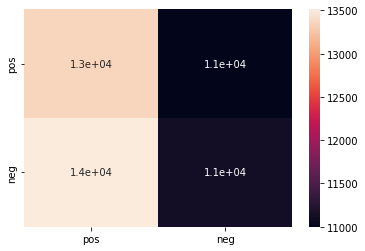

In [87]:
predicted_sentiments = NB_clf.predict(X_test_tfidf)
model_performance(y_test, predicted_sentiments)